## Intro
In this chapter we describe some characteristic of mid/high frequency order book data. We will describe geometric
properties of the feature space and their role in the prediction framework. We will start by introducing the 
data used and the feature space, why they were selected and their relation with the target variable. 
The description of the data will make use of some DSP techniques, that we will use without give any background, since
exposition of signal processing is outside the scope of this work.  
Good statistical signal processing references are McKay and Hamming. 
### Data Description
The data was collected from the binance exchange the 25th of february from 17:01:31 up to 22:25:06 for a total of 3512
data points. The data is sampled at 5s frequency and consists of:

* bid and ask prices at the top of the order book
* bid and ask sizes at the top of the order book
* aggregate sell and buy transaction volumes for the sampling interval (5s)

We added just one artificial feature, namely the order flow imbalance as specified by stoikov (where is showed that 
there is high correlation between price movemente and ofi).
Other common feature such as the bid ask spread or the mid price are just obtained by linear combination of the
features just described, and thus they introduce collinearity.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

plt.rc('figure',figsize=(10,6),dpi=100)

df = pd.read_csv('data/raw/data_binance.csv')
df.columns=['timestamp','ask','bid','ask_size','bid_size','sell_qty','buy_qty']
df.timestamp = pd.to_datetime(df.timestamp)
# df = df.set_index('timestamp').resample('10s').apply({'bid': np.mean, 
#                                                       'ask': np.mean,
#                                                       'bid_size': np.sum,
#                                                       'ask_size': np.sum,
#                                                       'sell_qty': np.sum,
#                                                       'buy_qty': np.sum
#                                                      })
df.set_index('timestamp',inplace=True)
df['ofi'] = (df.ask.diff() >= 0).astype(int) * df.ask_size.apply(np.abs) -\
              (df.ask.diff() <= 0).astype(int) * df.ask_size.apply(np.abs) -\
              (df.bid.diff() >= 0).astype(int) * df.bid_size.apply(np.abs) -\
              (df.bid.diff() <= 0).astype(int) * df.bid_size.apply(np.abs) 
df.head()

,ask,bid,ask_size,bid_size,sell_qty,buy_qty,ofi
timestamp,,,,,,,
2021-02-25 17:01:31.296035,50531.85,50528.71,0.260000,1.000000,15.656524,23.955780,0.000000
2021-02-25 17:01:36.794538,50530.12,50520.55,0.057893,0.435920,2.459863,4.371013,-0.493813
2021-02-25 17:01:42.284479,50527.46,50527.45,0.262615,0.740739,0.252142,1.297689,-1.003354
2021-02-25 17:01:47.767470,50546.39,50543.52,0.178088,0.060905,4.029092,1.010848,0.117183
2021-02-25 17:01:53.686262,50516.41,50512.42,0.007930,0.231455,2.226948,1.904901,-0.239385


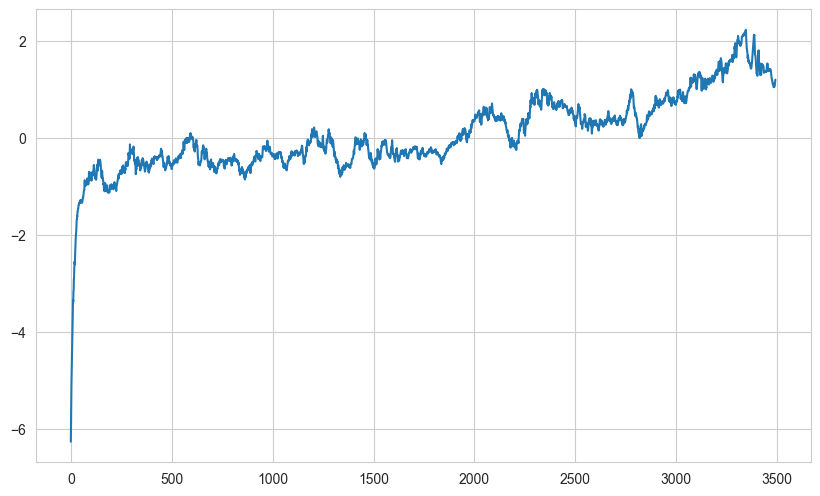

In [47]:
import scipy.signal as sg
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# df.plot(y=['ask','bid'])
# supersmoother
period = 20 
a = np.exp(-1.1414 * np.pi / period)
b = 2 * a * np.cos(1.1414* 180 / period)
c2 = b
c3 = -a*a
c1 = 1 - c2 - c3
mid = .5*(df.ask + df.bid)
fil = sg.lfilter([c1,c1], [2, c2, c3], mid.values)

fil_ = sc.fit_transform(fil.reshape(-1,1))
mid_ = sc.fit_transform(mid.values.reshape(-1,1))
plt.plot(fil_[period:] - mid_[period:])

Text(0, 0.5, 'PSD (dB)')

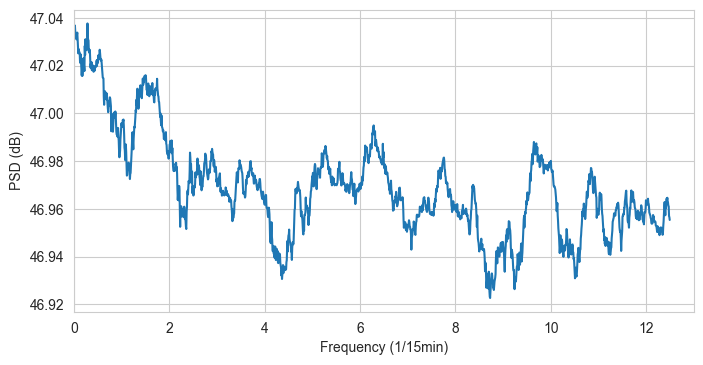

In [55]:
from scipy import fftpack
temp_fft = fftpack.fft(mid.values)
fftfreq = fftpack.fftfreq(df.shape[0],1/25)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
i = fftfreq > 0
ax.plot(fftfreq[i], 10 * np.log10(mid.values[i]))
ax.set_xlim(0, 13)
ax.set_xlabel('Frequency (1/15min)')
ax.set_ylabel('PSD (dB)')

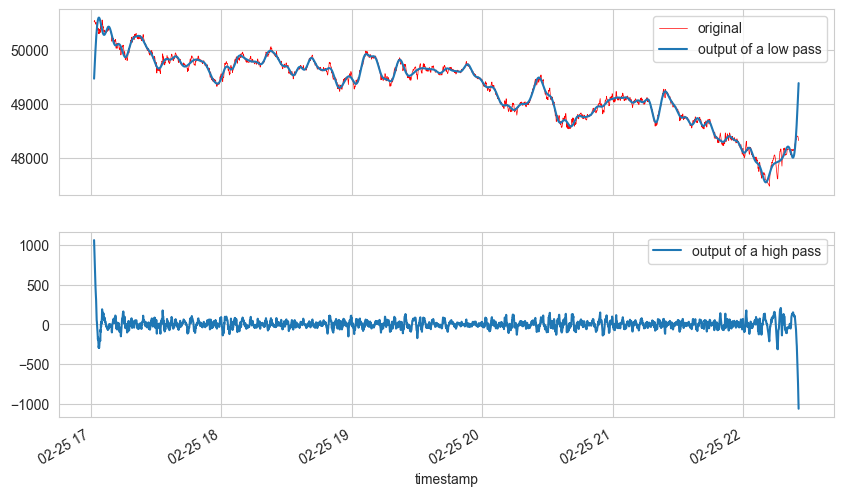

In [89]:
import scipy as sp
fig, ax = plt.subplots(2,1, sharex='all')
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > .5] = 0
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))
mid_res = mid.values - temp_slow
mid.plot(lw=.5,color='red',label='original',ax=ax[0])
pd.Series(temp_slow,index=mid.index).plot(ax=ax[0],label='output of a low pass')
pd.Series(mid_res,index=mid.index).plot(ax=ax[1],label='output of a high pass')
ax[0].legend()
ax[1].legend()

In [8]:
X1 = df.copy()
X2 = df.copy()
X1['u'] = df.bid.shift() - df.ask
X2['v'] = df.ask.shift() - df.bid

In [9]:
X1['u_prev'] = X1.u.shift(1)
X2['v_prev'] = X2.v.shift(1)
# X1['runs'] = X1.fillna(0).u.apply(np.sign).cumcount()
X1.head()

,ask,bid,ask_size,bid_size,sell_qty,buy_qty,ofi,u,u_prev
timestamp,,,,,,,,,
2021-02-25 17:01:31.296035,50531.85,50528.71,0.260000,1.000000,15.656524,23.955780,0.000000,NaN,NaN
2021-02-25 17:01:36.794538,50530.12,50520.55,0.057893,0.435920,2.459863,4.371013,-0.493813,-1.41,NaN
2021-02-25 17:01:42.284479,50527.46,50527.45,0.262615,0.740739,0.252142,1.297689,-1.003354,-6.91,-1.41
2021-02-25 17:01:47.767470,50546.39,50543.52,0.178088,0.060905,4.029092,1.010848,0.117183,-18.94,-6.91
2021-02-25 17:01:53.686262,50516.41,50512.42,0.007930,0.231455,2.226948,1.904901,-0.239385,27.11,-18.94


In [10]:
x1 = X1.dropna().drop('u',axis=1).values
x2 = X2.dropna().drop('v',axis=1).values

T,p = x1.shape

u = X1.dropna().u.values
v = X2.dropna().v.values

w1 = np.zeros((T,p))
w2 = np.zeros((T,p))
_w1 = np.zeros((T,p))
_w2 = np.zeros((T,p))

In [11]:
DEBUG = 1

QTY = 13
wealth = np.zeros(T)
eps = 0

def loss1(sign, t, eps = 30.):
    if sign > 0:
        return np.minimum(eps, sign*u[t]) 
    else:
        return 0
def loss2(sign, t ,eps = 30.):
    if sign < 0:
        return np.minimum(eps, sign * v[t]) 
    else:
        return 0


eps_u = np.ones(T) * 100
eps_v = np.ones(T) * 100

a = 3

M1 = a * np.eye(p)
M1_inv = 1/a * np.eye(p)
M2 = a * np.eye(p)
M2_inv = 1/a * np.eye(p)

errors = 0

for t in range(T-1):
    # prediction
    y_pred1 = np.sign(np.dot(w1[t],x1[t]))
    y_pred2 = np.sign(np.dot(w2[t],x2[t])) if y_pred1 !=1 else 1

    # suffer loss 
    gains1 = loss1(y_pred1, t, QTY)
    gains2 = loss2(y_pred2, t, QTY)
    wealth[t+1] = wealth[t] + gains1 + gains2

    # SOP Update
    mistake1 = y_pred1 * np.sign(u[t]) <= 0
    mistake2 = y_pred2 * np.sign(v[t]) <= 0
    
    if DEBUG:
        errors += int(mistake1) + int(mistake2)
    
    grad1 = x1[t] * np.sign(u[t]) * int(mistake1)
    grad2 = x2[t] * np.sign(v[t]) * int(mistake2)

    increase_1 = np.outer(x1[t],x1[t]) * int(mistake1)
    increase_2 = np.outer(x2[t],x2[t]) * int(mistake2)

    M1 = M1 + increase_1
    M1_inv = M1_inv - M1_inv.dot(increase_1).dot(M1_inv)/(1+ x1[t].dot(M1_inv).dot(x1[t]))
    M2 = M1 + increase_2
    M2_inv = M2_inv - M2_inv.dot(increase_2).dot(M2_inv)/(1+ x2[t].dot(M2_inv).dot(x2[t]))
    
    ### update 
    w1[t+1] = M1_inv.dot(_w1[t])
    _w1[t+1] = _w1[t] + grad1
    w2[t+1] = M2_inv.dot(_w2[t])
    _w2[t+1] = _w2[t] + grad2

print(f'accuracy {np.round(1-errors/(2*T),2)}')

accuracy 0.81


In [12]:
# compare the result with a only buy only sell strategy
a = 3

wealth_bo = np.zeros(T) # wealth buy only
wealth_so = np.zeros(T) # wealth sell only
errors = 0

for t in range(T-1):
    # suffer loss 
    wealth_bo[t+1] = wealth_bo[t] + loss1(1,t,QTY) + loss2(1,t,QTY)
    wealth_so[t+1] = wealth_so[t] + loss1(-1,t,QTY) + loss2(-1,t,QTY)


In [17]:
# randomly picks price direction according to a Bernoulli(.5)
from scipy.stats import bernoulli
wealth_ran = np.zeros(T) # random picks
errors = 0

for t in range(T-1):
    # suffer loss 
    direction1 = 1 - 2 * bernoulli.rvs(.5,size=1)
    direction2 = 1 - 2 * bernoulli.rvs(.5,size=1)
    wealth_ran[t+1] = wealth_ran[t] + loss1(direction1,t,QTY) + loss2(direction2,t,QTY)


In [18]:
# vanilla perceptron
w1 = np.zeros((T,p))
w2 = np.zeros((T,p))
wealth_per = np.zeros(T)
DEBUG = 1


for t in range(T-1):
    # prediction
    y_pred1 = np.sign(np.dot(w1[t],x1[t]))
    y_pred2 = np.sign(np.dot(w2[t],x2[t])) if y_pred1 !=1 else 1

    # suffer loss 
    gains1 = loss1(y_pred1, t, QTY)
    gains2 = loss2(y_pred2, t, QTY)
    wealth_per[t+1] = wealth_per[t] + gains1 + gains2

    # SOP Update
    mistake1 = y_pred1 * np.sign(u[t]) <= 0
    mistake2 = y_pred2 * np.sign(v[t]) <= 0
    
    if DEBUG:
        errors += int(mistake1) + int(mistake2)
    
    grad1 = x1[t] * np.sign(u[t]) * int(mistake1)
    grad2 = x2[t] * np.sign(v[t]) * int(mistake2)

    ### update 
    w1[t+1] = w1[t] + grad1
    w2[t+1] = w2[t] + grad2

print(f'accuracy {np.round(1-errors/(2*T),2)}')

accuracy 0.55


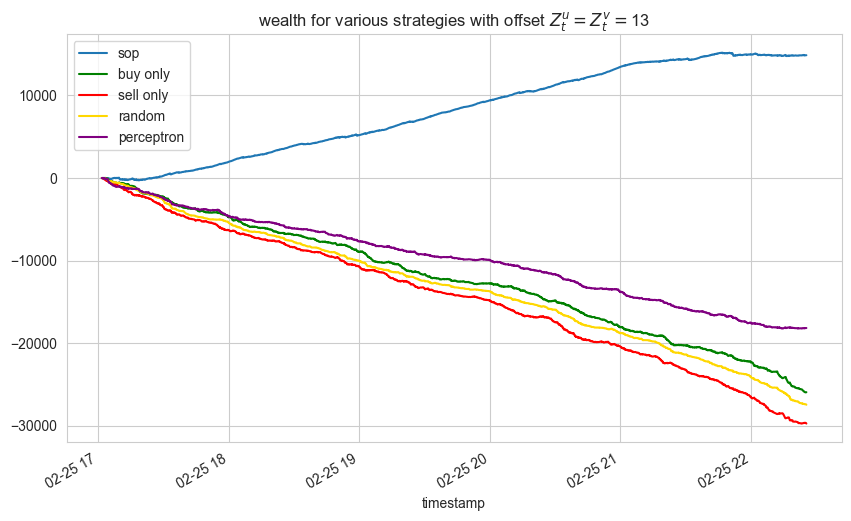

In [19]:
sns.set_style('whitegrid')
plt.figure(figsize=(10,6), dpi=100)
pd.Series(wealth,index=X1.dropna().index).plot(label='sop')
pd.Series(wealth_bo,index=X1.dropna().index).plot(label='buy only',color='green')
pd.Series(wealth_so,index=X1.dropna().index).plot(label='sell only',color='red')
pd.Series(wealth_ran,index=X1.dropna().index).plot(label='random',color='gold')
pd.Series(wealth_per,index=X1.dropna().index).plot(label='perceptron',color='purple')
plt.legend()
_= plt.title(f'wealth for various strategies with offset $Z_t^u = Z_t^v=${QTY}')

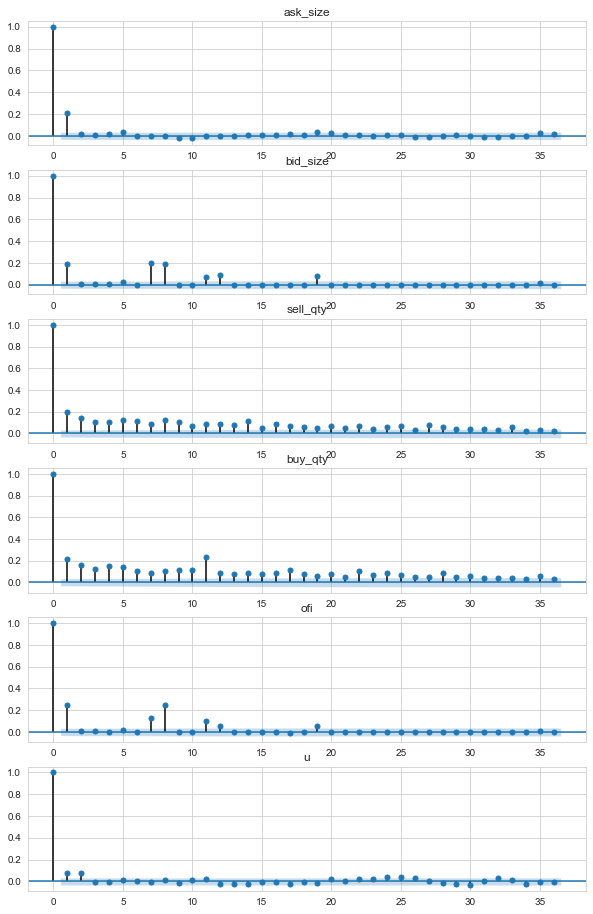

In [16]:
# why the whitening perceptron does work?
import statsmodels.api as sm
cols = ['ask_size','bid_size','sell_qty','buy_qty','ofi','u']
fig, ax = plt.subplots(len(cols),1,figsize=(10,16))
for i in range(len(cols)):
    _ = sm.graphics.tsa.plot_acf(X1.dropna()[cols[i]], ax=ax[i])
    ax[i].set_title(cols[i])

### Why the whitened perceptron works
* Inspecting the acfplots above we see that features presents significant autocorrelation, which intuitively implies that $x_t$ is correlated with $x_{t-1},x_{t-2}$ and so on. Suppose the binary classification problems both for the sign of $u_t$ and $v_t$ are 
linearly separable. The vanilla perceptron will tilt the separating hyperplanes towards all the previous values 
for $x_t$ leaving the perceptron prone to mistakes, when a large uncorrelated feature $x_{t+1}$ arrives

* The feature vectors have values that greatly differ in magnitude, the rescaling is recommended, and in the
2nd order perceptron rescaling is obtained by premultiplying by $M^{-1/2}$:

The bound on the mistakes made by the second order perceptron is given by :

$$
\sum_{t=1}^T \mathbb{I}_{d_t^u \neq \tilde{u}} \le \inf_{y > 0} \min_{w \in \mathbb{R}^d} \frac{L_{\gamma,T}(w)}{\gamma}  + \frac{1}{\gamma} \sqrt{
\left( a \|w\|^2 + w^T A_n w \right) \sum_{i=1}^d \ln \left(1 + \frac{\lambda_i}{a} \right)
}
$$

where:
$$
L_{\gamma,T}(w) = \sum_{t=1}^T(\gamma - \tilde{u_t} w \cdot x_t)^2 \mathbb{I}_{y_t w \cdot x_t < 0} 
$$

## Magnitude prediction
Now that we have choosen a decent classifier, we have to decide the offset (number of ticks) at which we place
the market order. When decent accuracy is achieved, the agent is practically able to make a profit after $T$ trading
rounds.  

The closed form expression for the profit would encourage any forecaster, to shoot for the highest value of $Z_t$,
since max profit is capped at $u_{t+1}$ or $v_{t+1}$ for any correct prediction.  
In real world scenario, in case of correct price direction prediction, overshooting the value of $u_t$ (for example) will most definitively lead to an unfilled order. The agent, however, can potentially recover from such a situation
(by simply cancelling the limit order 
and issuing a market order at $a_t + u_{t+1}$ and eventually paying extra taker fees).  
We can however cast the problem into prediction with expert advice. To each expert we associate a value $\epsilon$
in a equally spaced partition range $\Pi = \{z_{min}, z_{min}+\delta, \ldots, z_{max} - \delta, z_{max}\}$ where $\delta$ is
a multiple of tick size, and $z_{min},z_{max}$ are predetermined parameters. 

In particular to discourage expert $\epsilon$ to exceed $|u_t|$ we can reward each expert with gain per round : $\min(\epsilon, 
|u_t|)$ if $\epsilon \le |u_t|$ and $0$ otherwise. 
Let $H_{i,t}$ be the cumulative reward associated to the $i$-th expert up to time $t$, that is:

$$
H_{i,t} = \sum_{s =1}^t \underbrace{\min(z_{i}, |u_s|) \mathbb{I}_{z_{i} \le |u_s|}}_{h_{s,i}}
$$

The forecaster then will issue a limit order at price:

$$
Z_t^u = \sum_{i=1}^N  \frac{z_i H_{i,t}}{\sum_{i=1}^N H_{i,t}} = \sum_{i=1}^N z_i p_{t,i}
$$

Where $N = |\Pi|$ is the size of the partition. $p_t$ is a probability distribution on the $N$ dimensional simplex.
The above algorithm is equivalent to the Hedge algorithm with weights given by $\exp(\log \frac{H_{t,i}}{H_{t-1,i}})$
$i = 1\ldots N$.  

In [11]:
    x1 = X1.dropna().drop('u',axis=1).values
x2 = X2.dropna().drop('v',axis=1).values

T,p = x1.shape

w1 = np.zeros((T,p))
w2 = np.zeros((T,p))
_w1 = np.zeros((T,p))
_w2 = np.zeros((T,p))

errors = 0
epss = np.arange(20.,30.,1.)
d = epss.shape[0]

mix1 = np.ones((T,d))/d
mix2 = np.ones((T,d))/d

prec1 = np.ones((T,d)) * 1e-8
prec2 = np.ones((T,d)) * 1e-8

a = 3

M1 = a * np.eye(p)
M1_inv = 1/a * np.eye(p)
M2 = a * np.eye(p)
M2_inv = 1/a * np.eye(p)

lam = .03

def loss1(sign, t, eps = 3.):
    if sign > 0:
        return np.minimum(eps, sign*u[t]) 
    else:
        return 0
def loss2(sign, t ,eps = 3.):
    if sign < 0:
        return np.minimum(eps, sign * v[t]) 
    else:
        return 0
    
def backtest(init_cap = 300, eta1 = .1, eta2 = .1):
    global errors,M1,M2,M1_inv,M2_inv
    wealth = np.zeros(T)
    wealth[0] = init_cap
    for t in range(T-1):
        # prediction
        y_pred1 = np.sign(np.dot(w1[t],x1[t]))
        y_pred2 = np.sign(np.dot(w2[t],x2[t])) if y_pred1 !=1 else 1

        # experts update
        for i in range(d):
            prec1[t+1,i] = prec1[t,i] + epss[i] if epss[i] <= np.abs(u[t]) else 1e-8
            prec2[t+1,i] = prec2[t,i] + epss[i] if epss[i] <= np.abs(v[t]) else 1e-8
            
            
        # forecaster prec
        e1 = (prec1[t]/prec1[t].sum()).dot(epss)
        e2 = (prec2[t]/prec2[t].sum()).dot(epss)
        
        g1 = loss1(y_pred1,t, e1)
        g2 = loss2(y_pred2,t, e2)
        
        wealth[t+1] = wealth[t] + g1 + g2

        # SOP Update
        mistake1 = y_pred1 * np.sign(u[t]) <= 0
        mistake2 = y_pred2 * np.sign(v[t]) <= 0

        if DEBUG:
            errors += int(mistake1) + int(mistake2)

        grad1 = x1[t] * np.sign(u[t]) * int(mistake1)
        grad2 = x2[t] * np.sign(v[t]) * int(mistake2)

        increase_1 = np.outer(x1[t],x1[t]) * int(mistake1)
        increase_2 = np.outer(x2[t],x2[t]) * int(mistake2)

        M1 = M1 + increase_1
        M1_inv = M1_inv - M1_inv.dot(increase_1).dot(M1_inv)/(1+ x1[t].dot(M1_inv).dot(x1[t]))
        M2 = M1 + increase_2
        M2_inv = M2_inv - M2_inv.dot(increase_2).dot(M2_inv)/(1+ x2[t].dot(M2_inv).dot(x2[t]))

        ### update 
        w1[t+1] = M1_inv.dot(_w1[t])
        _w1[t+1] = _w1[t] + grad1
        w2[t+1] = M2_inv.dot(_w2[t])
        _w2[t+1] = _w2[t] + grad2

    if DEBUG:
        print(f'accuracy {np.round(1-errors/(2*T),2)}')
    return wealth
            
wealth = backtest()

accuracy 0.81


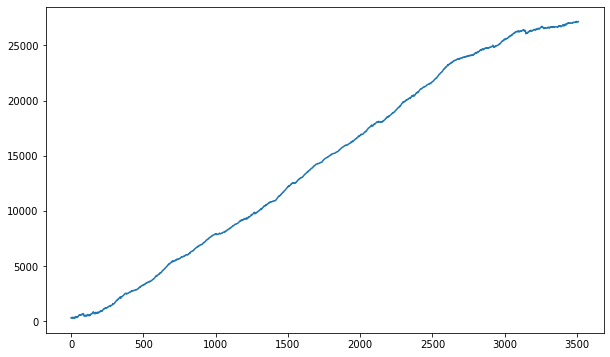

In [12]:
plt.figure(figsize=(10,6))
pd.Series(wealth).plot()

In [13]:
# from empyrical import cum_returns, max_drawdown, calmar_ratio, sharpe_ratio
rets = pd.Series(wealth,index=X1.dropna().index).pct_change().dropna()
max_drawdown = rets.min()
sharpe_ratio = rets.mean()/rets.std()
omega_ratio = rets.mean()/(-max_drawdown)

In [14]:
max_drawdown, sharpe_ratio, omega_ratio

(-0.12929577185172259, 0.11911682360308992, 0.010441491818322077)

### Commenti
La soluzione mi sembra soddisfacente.
Il livello di rischio (drawdown) e' abbastanza contenuto. Ho cambiato approccio rispetto, visto che praticamente ho fatto due problemi di classificazione in parallelo, invece che uno come in precedenza.

In [91]:
q_sell = df.sell_qty.quantile([.1,.9]).values
q_buy = df.buy_qty.quantile([.1,.9]).values
s_ask = df.ask_size.quantile([.1,.9]).values
s_bid = df.bid_size.quantile([.1,.9]).values

In [92]:
qty = pd.concat([-df.sell_qty[(df.sell_qty < q_sell[1])],\
           df.buy_qty[(df.buy_qty < q_buy[1])]])
size = pd.concat([-df.ask_size[(df.ask_size < s_ask[1])],\
           df.bid_size[(df.bid_size < s_bid[1])]])

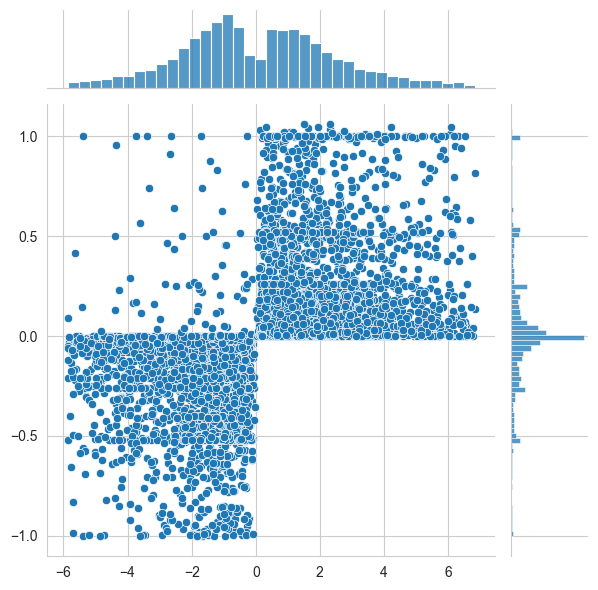

In [93]:
N = min(qty.shape[0], size.shape[0])
sns.jointplot(x=qty.values[:N],y=size.values[:N])

In [106]:
np.corrcoef(x = qty[qty > 0].values[:N], y=size[size > 0].values[:N])

array([[ 1.       , -0.0061467],
       [-0.0061467,  1.       ]])

- [ ] best expert
- [X] strategia baseline molto semplice
- [ ] strategia che si basa sul fatto che il trend precedente funziona
- [ ] Running average negli ultimi es 10 gg (nessuno delle cose che ho fatto tiene conto della stazionarieta')
- [ ] Formula il problema e poi parla dei dati

al: cesa.bianchi@gmail.com

Se hai tempo prova a vedere l'aspetto moltiplicativo,
la media mobile, benchmark, (baseline che usa glistessi dati). Se hai tempo da qui all'otto puoi esplorare l'aspetto
moltiplicativo, pero' e' piu' realistico.

In [114]:
np.abs(size).mean(), np.abs(qty).mean()

(0.22000786737145567, 1.9796101101265886)

In [115]:
other = df.copy()
df['obi']=(df.buy_qty - df.sell_qty)/(df.buy_qty + df.sell_qty)

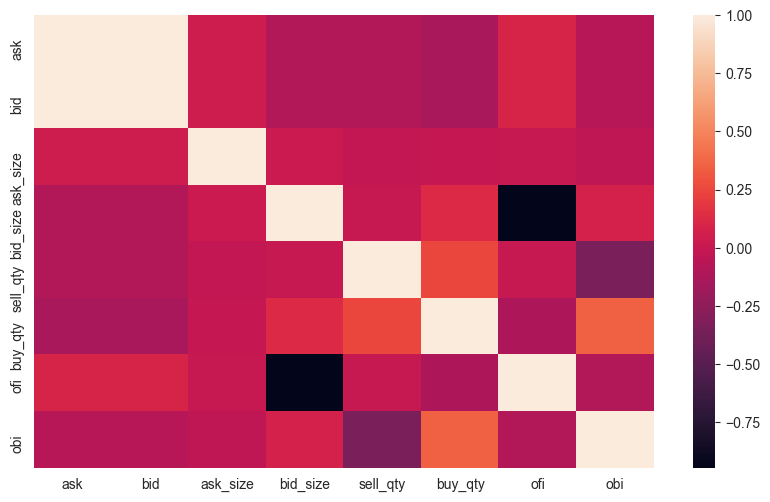

In [119]:
sns.heatmap(df.corr())

In [120]:
sns.plot()

,ask,bid,ask_size,bid_size,sell_qty,buy_qty,ofi,obi
timestamp,,,,,,,,
2021-02-25 17:01:31.296035,50531.85,50528.71,0.260000,1.000000,15.656524,23.955780,0.000000,0.209512
2021-02-25 17:01:36.794538,50530.12,50520.55,0.057893,0.435920,2.459863,4.371013,-0.493813,0.279781
2021-02-25 17:01:42.284479,50527.46,50527.45,0.262615,0.740739,0.252142,1.297689,-1.003354,0.674620
2021-02-25 17:01:47.767470,50546.39,50543.52,0.178088,0.060905,4.029092,1.010848,0.117183,-0.598865
2021-02-25 17:01:53.686262,50516.41,50512.42,0.007930,0.231455,2.226948,1.904901,-0.239385,-0.077943
